In [ ]:
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

In [2]:
# Install required libraries
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('dengue_data_with_weather_data.csv')

print("Original Dataset Shape:", df.shape)
print(df.head())

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.dropna(inplace=True)

# Sort properly
df.sort_values(['District', 'Year', 'Month'], inplace=True)

# Create lag feature
df['Lagged_Cases'] = df.groupby('District')['Cases'].shift(1)
df['Lagged_Cases'] = df['Lagged_Cases'].fillna(0)

# One-hot encode District
encoder = OneHotEncoder(sparse_output=False)
district_encoded = encoder.fit_transform(df[['District']])
district_cols = encoder.get_feature_names_out(['District'])

df_encoded = pd.DataFrame(district_encoded,
                          columns=district_cols,
                          index=df.index)

df = pd.concat([df.drop(['District', 'Province'], axis=1), df_encoded], axis=1)

# Define features
numerical_features = [
    'Year', 'Month', 'Latitude', 'Longitude', 'Elevation',
    'Temp_avg', 'Precipitation_avg', 'Humidity_avg', 'Lagged_Cases'
]

features = numerical_features + list(district_cols)

X = df[features]
y = df['Cases']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessed Shape:", X.shape)

Original Dataset Shape: (900, 11)
   Year Province  District  Latitude  Longitude  Elevation  Month  Cases  \
0  2019  Western   Colombo  6.924429   79.90725          4      1   1225   
1  2019  Western   Gampaha  7.065026   79.96622         19      1    724   
2  2019  Western  Kalutara  6.572935   80.02519          5      1    372   
3  2019  Central     Kandy  7.275923   80.62659        499      1    288   
4  2019  Central    Matale  7.486819   80.52632        362      1     62   

    Temp_avg  Precipitation_avg  Humidity_avg  
0  26.914286           0.771429     72.607143  
1  27.417857           0.728571     69.892857  
2  26.112500           1.396429     80.464286  
3  22.067857           1.853571     83.428571  
4  25.592857           0.850000     74.285714  
Preprocessed Shape: (900, 34)


Test RMSE: 207.64
Test MAE: 75.73


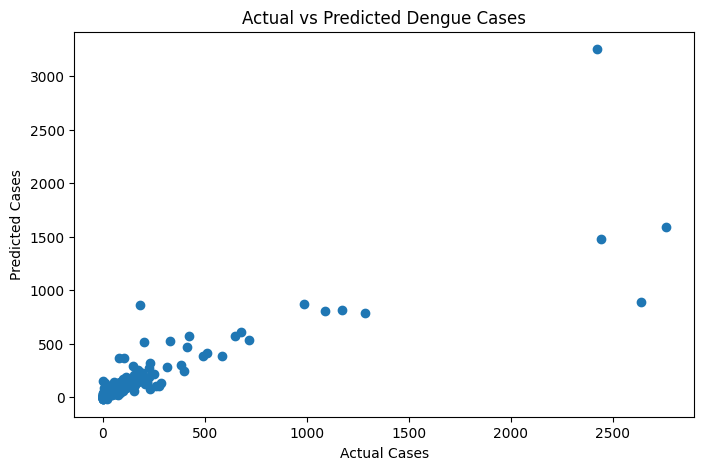

In [3]:
from xgboost import DMatrix, train
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert to DMatrix
train_dmatrix = DMatrix(X_train, label=y_train)
test_dmatrix = DMatrix(X_test, label=y_test)

# Parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 4,
    'seed': 42
}

# Train model
model = train(
    params,
    train_dmatrix,
    num_boost_round=150
)

# Predictions
y_pred = model.predict(test_dmatrix)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted Dengue Cases")
plt.show()

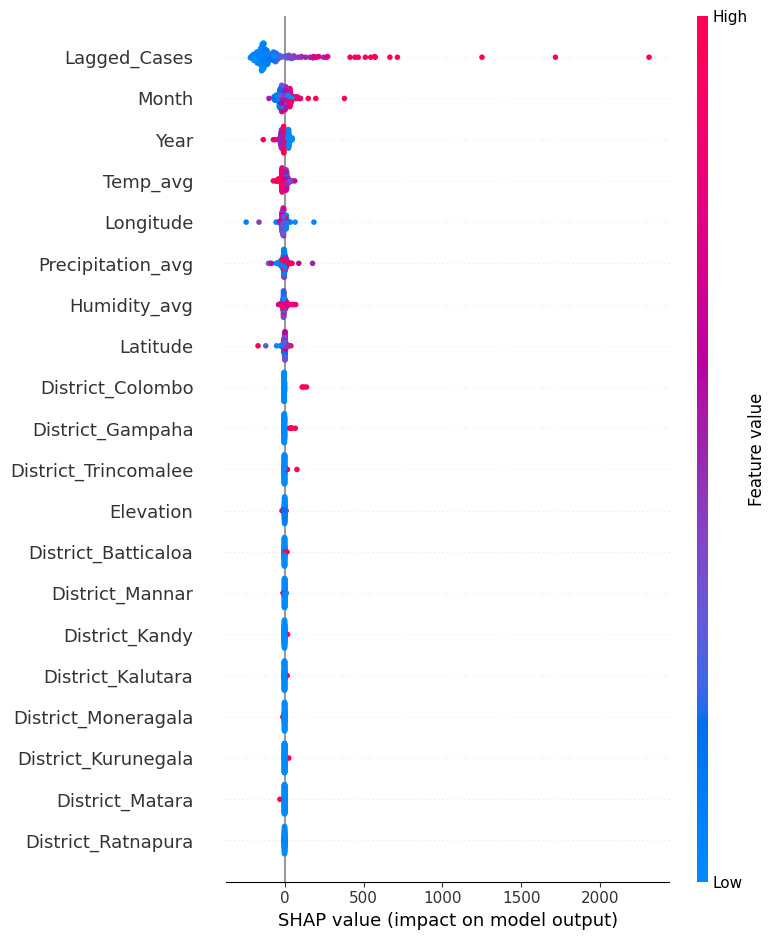

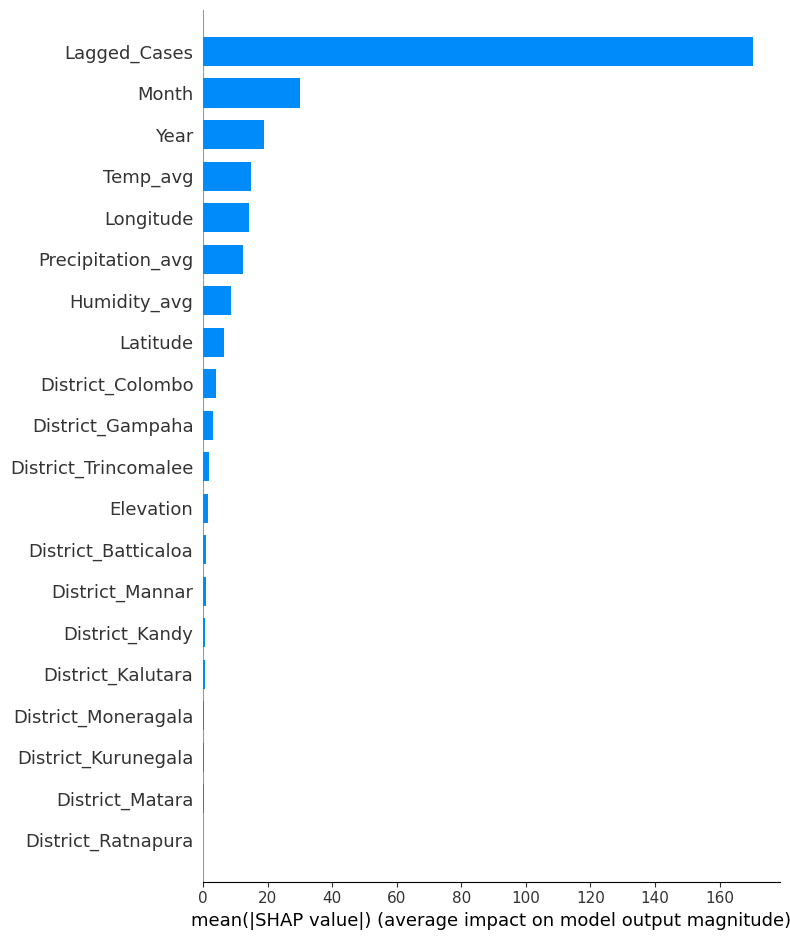

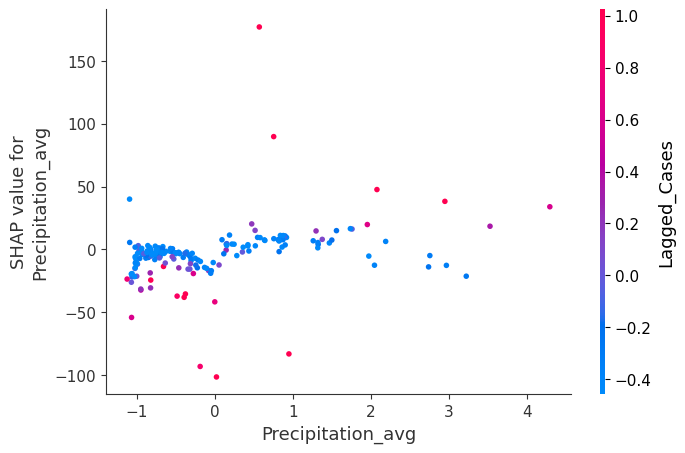

In [4]:
import shap

# SHAP needs original (not scaled) values for better interpretation
X_test_df = pd.DataFrame(X_test, columns=features)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_df)

# Summary Plot
shap.summary_plot(shap_values, X_test_df)

# Feature Importance Bar Plot
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Dependence Plot (example feature)
shap.dependence_plot("Precipitation_avg", shap_values, X_test_df)

In [5]:
import joblib
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']